<center>

*******************************************************************************************

### REDUCED RECTIFIED
### MULTIGRANULAR 
### TEMPORAL SEGMENTATION
  
#####  14 May 2024

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

#### INFORMATION:


* Description:

    Compute multigranular and rectified temporal segmentation of a multi-dimensional
    time-series or otherwise ordered data in a CSV file. <br>
    More information in Mendoza et al. (2022) https://doi.org/10.5281/zenodo.7243875
  
* Instructions:

    Edit the values indicated with an input_arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************


In [ ]:
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, floor
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist, squareform

***
## Path & parameters

In [2]:
src_data_folder = r"C:\Users\Percival_Lowell\Documents\Data\SPHERE_data" # <--- full path where CSV files are (prepend r)
src_data_fn = 'SPHERE_raw_accel_001.csv' # <--- name of CSV file with extension
tgt_data_folder = src_data_folder # <--- full path to save CSV file with segmentation data (prepend r)

delete_col = 0 # <--- [int] = remove this column, empty = don't. Often useful to get rid of an index (e.g., timestamp)

length_limit = 2000 # <--- length limit to prevent taking too much time. If necessary to reduce size, equally-sized chunks will be averaged.
ksf = range(6,26,2) # <--- novelty kernel size factors respect to total length
pkt = 0.2 # <--- novelty peak threshols (determines segementation boundaries) in [0...1]
max_gran = 3 # <--- maximum number of granularity levels (less than number of novelty kernels)

vis_opt = 1 # <--- 1 = show visualisations, 0 = don't

# "SPHERE_raw_accel_001.csv" (originally data/raw/001/accel.csv) was taken from
# Tonkin et al. (2022) https://doi.org/10.5523/bris.2h0wyctxrd69j2oqccsi45hy1p

***
## Open CSV file and reduce data

CSV file loaded


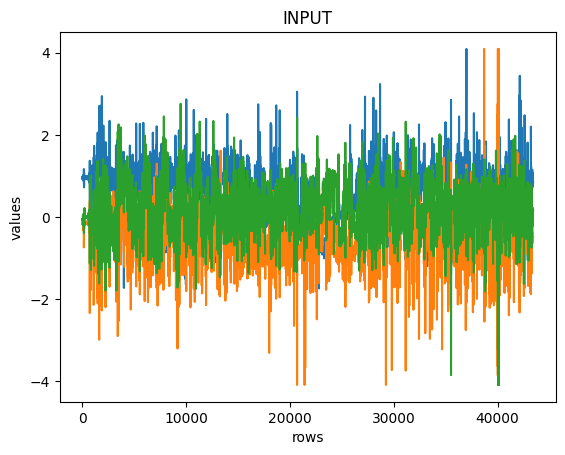

In [3]:
full_src_fn = src_data_folder+'\\'+src_data_fn
data_df = pd.read_csv(full_src_fn)

if isinstance(delete_col,int):
    data_df.drop(data_df.columns[delete_col], axis=1, inplace=True)

if vis_opt:

    plt.plot(data_df)
    plt.title('INPUT')
    plt.xlabel('rows')
    plt.ylabel('values')

print('CSV file loaded')


raw data length = 43423
reduced data length = 1973


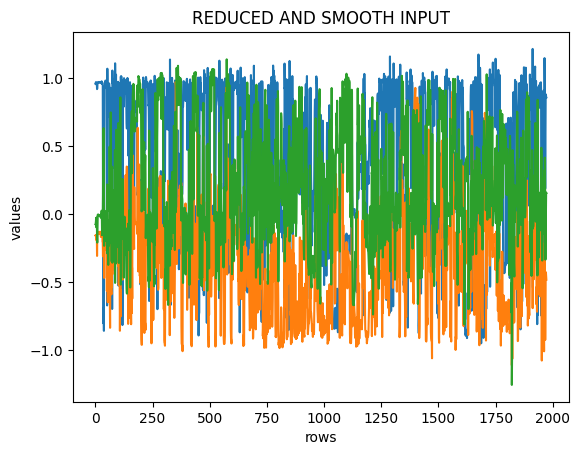

In [4]:
print('raw data length = '+str(data_df.shape[0]))
rf = ceil(data_df.shape[0] / length_limit)
if rf > 1:

    length_rs =  rf * int(len(data_df)/rf)
    data_arr = np.zeros((int(length_rs/rf),data_df.shape[1]))
    for i_col in range(data_df.shape[1]):
        data_arr[:,i_col] = np.mean(data_df.to_numpy()[:length_rs,i_col].reshape(-1, rf), 1)
    print('reduced data length = '+str(data_arr.shape[0]))

    if vis_opt:

        plt.plot(data_arr)
        plt.title('REDUCED AND SMOOTH INPUT')
        plt.xlabel('rows')
        plt.ylabel('values') 
    
else:
    data_arr = data_df.to_numpy()
    print('data was not reduced')
    

***
## Multigranular Segmentation

In [5]:
def mg_seg(input_arr,nks_l,sdf,pkt):

    """
    Computes multigranular segmentation.
    
    INPUT:
        input_arr: a numpy array with the input data
        nks_l: list of even integers, sizes of novelty kernels
        sdf: proportion of the kernel for the standard deviation of the Gaussian taper
        pkt: novelty peak threshold (determines segmentation boundary) in [0...1]

    OUTPUT:
        seg_idx_nl: a nested list array with the indices of the segment boundaries
        nov_mtx: matrix of raw novelty scores
        snov_mtx: matrix of gaussian-filtered novelty scores rescaled to [0,1]
        dist_m: the distance matrix
    """

    for nk_size in nks_l:
    
        if nk_size%2: # is odd
            print('Error: nk_sizes should be an even number.')
            exit(1)

    def gausswin(size,sd):
            x = np.linspace(-int(size/2),int(size/2),size)
            return 1. / np.sqrt( 2. * np.pi * sd**2 ) * np.exp( -x**2 / ( 2. * sd**2 ) )
            
    dist_m = squareform( pdist( np.column_stack( (input_arr, input_arr) ) , 'euclidean') )

    nov_mtx = np.zeros([ len(nks_l) , input_arr.shape[0] ])
    snov_mtx = np.copy(nov_mtx)
    seg_idx_nl = []

    mtx_row = 0
    for nk_size in nks_l:

        # Novelty:
        sd = nk_size/sdf # kernel's gaussian taper standard deviation
        kernel_size_half = int(nk_size/2)
        xx = np.linspace(-kernel_size_half,kernel_size_half,nk_size)
        yy = np.linspace(-kernel_size_half,kernel_size_half,nk_size)
        xx, yy = np.meshgrid(xx, yy)
        gauss_2D = 1. / (2. * np.pi * sd**2) * np.exp(-(xx**2. / (2. * sd**2.) + yy**2. / (2. * sd**2.)))
        kron_cb = np.kron( [[-1,1],[1,-1]] , np.ones( (kernel_size_half,kernel_size_half) ) )
        gausscb_kernel = gauss_2D * kron_cb
        for i_start in np.arange(0,input_arr.shape[0]-nk_size):
            i_end = i_start + nk_size
            nov_mtx[ mtx_row, i_start + kernel_size_half ] = np.sum( gausscb_kernel * dist_m[ i_start:i_end , i_start:i_end ] )

        # Gaussian filter: 
        gf_size = int(nk_size/4)
        if gf_size%2: # is odd
            gf_size += 1
        gf_sd = int(gf_size/4)
        gaussian_window =  gausswin(gf_size,gf_sd)
        snov_mtx[mtx_row] = np.convolve(nov_mtx[mtx_row], gaussian_window, mode="same")

        mtx_row += 1

    # Normalise it, don't criticise it:
    snov_mtx = snov_mtx - np.min(snov_mtx)
    snov_mtx = snov_mtx / np.max(snov_mtx)
    
    mtx_row = 0
    for nk_size in nks_l:
  
        # Peaks (segment boundaries):
        pks_idx = find_peaks(snov_mtx[mtx_row])[0]
        pks_val = np.array(list(zip(pks_idx, snov_mtx[mtx_row][pks_idx])))
        seg_idx_nl.append([index for index, value in pks_val if value > pkt]) # index of peaks over threshold

        mtx_row += 1
        
    return seg_idx_nl, nov_mtx, snov_mtx, dist_m


MULTIGRANULAR SEGMENTATION computation time: 1.64387 s.


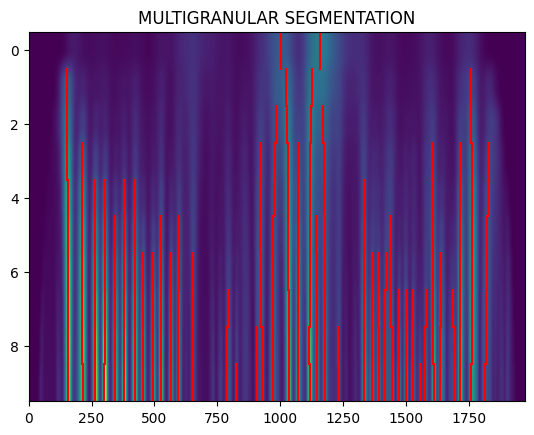

In [6]:
nks_l = []
for this_ksf in ksf:
    val = int(np.floor(data_arr.shape[0]/this_ksf))
    if val%2:
        val += 1
    nks_l.append(val)    

tic = time.time()
seg_idx_nl, nov_mtx, snov_mtx, dist_m = mg_seg(data_arr,nks_l,4,pkt)
toc =  time.time() - tic

print( 'MULTIGRANULAR SEGMENTATION computation time: %0.5f s.' % toc )

if vis_opt:
    
    plt.imshow(snov_mtx, aspect="auto")
    plt.title('MULTIGRANULAR SEGMENTATION')
    axes = plt.gca()
    ylim = axes.get_ylim()
    ystep = 1/len(seg_idx_nl)
    ymax = 1
    for i in range(len(seg_idx_nl)):
        ymin = ymax-ystep
        for x in seg_idx_nl[i]:
            plt.axvline(x, ymin, ymax, color = 'r')
        ymax -= ystep

***
## Rectification

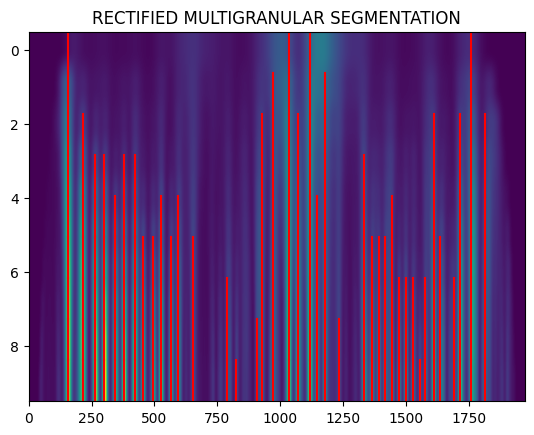

In [7]:
if len(seg_idx_nl) == 1:

    rect_seg_idx_nl = copy.deepcopy(seg_idx_nl)
else:
    tolerance = floor(min( np.diff(seg_idx_nl[len(seg_idx_nl)-1]) ) / 2 - 1)
    if tolerance < 0:
        tolerance = 0
    end = len(seg_idx_nl)-1
    rect_seg_idx_nl = []
    rect_seg_idx_nl.append(copy.deepcopy(seg_idx_nl[end]))

    for rect_b_i in range(len(seg_idx_nl[end])):
    
        rect_b = seg_idx_nl[end][rect_b_i]
        seg_col_i = rect_b_i
        seg_row_i = end
        rect_row_i = 1
        keep_going = True
    
        while (keep_going == True) and (seg_row_i >= 0):
            
            this_b = seg_idx_nl[seg_row_i][seg_col_i]
            
            other_i_arr = np.where(( seg_idx_nl[seg_row_i - 1] < (this_b+tolerance) ) & ( seg_idx_nl[seg_row_i - 1] > (this_b-tolerance) ))[0]
    
            seg_row_i -= 1
            
            if other_i_arr.size > 0:
    
                if rect_row_i >= len(rect_seg_idx_nl):
                    rect_seg_idx_nl.append([])
                rect_seg_idx_nl[rect_row_i].append(rect_b)
                rect_row_i += 1
                seg_col_i = other_i_arr[0]
            else:
                keep_going = False
            
    rect_seg_idx_nl.reverse()

if vis_opt:
    
    plt.imshow(snov_mtx, aspect="auto")
    plt.title('RECTIFIED MULTIGRANULAR SEGMENTATION')
    axes = plt.gca()
    ylim = axes.get_ylim()
    ystep = 1/len(rect_seg_idx_nl)
    ymax = 1
    for i in range(len(rect_seg_idx_nl)):
        ymin = ymax-ystep
        for x in rect_seg_idx_nl[i]:
            plt.axvline(x, ymin, ymax, color = 'r')
        ymax -= ystep
        

***
## Reduction of segmentation boundaries

granularity levels retained = 3


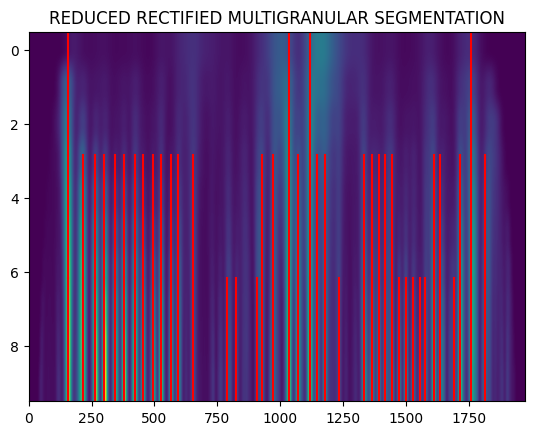

In [16]:
if max_gran >= len(ksf):
    raise Exception("Maximum number of granularity levels should be less than number of novelty kernels.")

if len(rect_seg_idx_nl) in [1,2] :

    red_rect_seg_idx_nl = copy.deepcopy(rect_seg_idx_nl)
else:
    L = ( list(len(x) for x in rect_seg_idx_nl))
    dL = np.diff(L)
    dLc = [(dL[i]+dL[i+1]) for i in range(len(dL)-1)]
    i_rank = np.argsort(dLc)
    i_sel_no_ex =  np.sort( i_rank[ len(i_rank) - max_gran  + 2: len(i_rank) ]) + 1 
    i_keep = [0]
    i_keep.extend([i for i in i_sel_no_ex])
    i_keep.append(len(rect_seg_idx_nl)-1)
    red_rect_seg_idx_nl = [rect_seg_idx_nl[i] for i in i_keep]

if vis_opt:
    
    plt.imshow(snov_mtx, aspect="auto")
    plt.title('REDUCED RECTIFIED MULTIGRANULAR SEGMENTATION')
    axes = plt.gca()
    ylim = axes.get_ylim()
    ystep = 1/len(red_rect_seg_idx_nl)
    ymax = 1
    for i in range(len(red_rect_seg_idx_nl)):
        ymin = ymax-ystep
        for x in red_rect_seg_idx_nl[i]:
            plt.axvline(x, ymin, ymax, color = 'r')
        ymax -= ystep

print('granularity levels retained =', len(red_rect_seg_idx_nl))

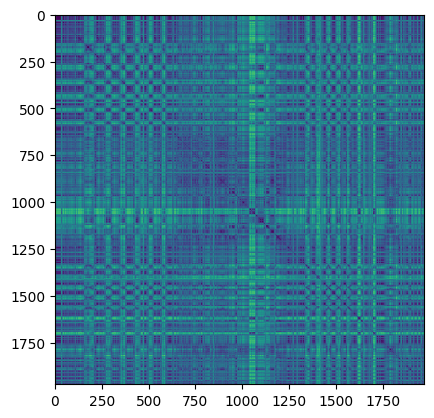

In [18]:
# Just to double-check, a heatmap of the self-similarity matrix:

if vis_opt:
    plt.imshow(dist_m)
